In [126]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 
import cv2

from matplotlib.colors import hsv_to_rgb , rgb_to_hsv
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D
import gc 
import time

from sklearn import linear_model

(298, 302, 3)


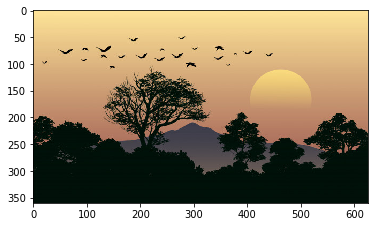

In [213]:
def read_im(fn) :
    return plt.imread(fn)/255
img1 = read_im("img1.jpg")
img2 = read_im("img2.jpg")
img3 = read_im("img3.jpg")
img4 = read_im("img4.jpg")
img5 = read_im("img5.jpg")
img6 = read_im("img6.jpg")
print(img5.shape)
plt.imshow(img5)
plt.imshow(img6)

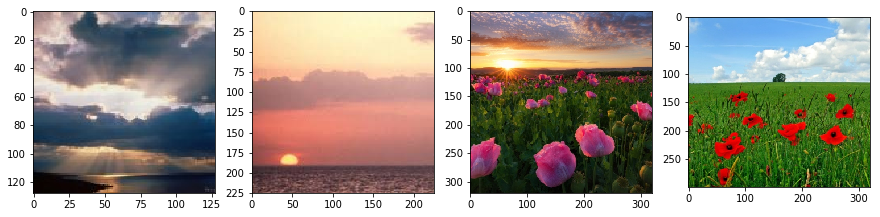

In [15]:
#Data visualization
plt.figure(figsize= (15, 80))

plt.subplot(141)
plt.imshow(img1)

plt.subplot(142)
plt.imshow(img2)

plt.subplot(143)
plt.imshow(img3)

plt.subplot(144)
plt.imshow(img4)

plt.show()

In [139]:
def show_im(arr):
    arr3 = arr.copy()
    arr3[arr3 == -100] = 0
    plt.grid(False)
    plt.imshow(arr3)

def show_imgs_results ( img1 , img2 , img3 ): 

    plt.figure(figsize= (15, 80))

    plt.subplot(131)
    show_im(img1)
    plt.title('Original image')

    plt.subplot(132)
    show_im(img2)
    plt.title('Damaged image')

    plt.subplot(133)
    show_im(img3)
    plt.title('Restored image')

    plt.show()
def del_patch(img_arr, x_c, y_c, h):
    hole_arr = img_arr.copy()
    for i in range(int(x_c-h//2),int(x_c+h//2)):
        for j in range(int(y_c-h/2),int(y_c+h/2)):
            hole_arr[i,j] = np.array([-100,-100,-100])
    return hole_arr

def get_patch(img_arr, x_c, y_c, h):
    start_x, start_y = int(x_c - h//2), int(y_c - h//2)
    end_x, end_y = int(x_c + h//2), int(y_c + h//2)
    return img_arr[start_x:end_x, start_y:end_y, :].copy()

def fill_patch(img_arr, x_c, y_c, h, values):
    start_x, start_y = int(x_c - h//2), int(y_c - h//2)
    end_x, end_y = int(x_c + h//2), int(y_c + h//2)
    img_arr[start_x:end_x, start_y:end_y, :] = values.reshape(h,h,3)
    
def naive_high_priority_pixel (img_arr, h, boundary_pixels):
    priority = -1 
    prior_pixel = (-1,-1)
    prior_patch = None
    for pixel in boundary_pixels :
        p = get_patch ( img_arr , pixel[0] , pixel[1] , h ).ravel()
        count_px_complete = np.argwhere(p != -100).shape[0]
        if ( count_px_complete > priority ):
            priority = count_px_complete
            prior_pixel = pixel
            prior_patch = p
            
    return prior_pixel , prior_patch

def get_boundary_pixels(img_arr):
    channel1 = img_arr[:,:,0].reshape(img_arr.shape[0], img_arr.shape[1])
    w, h = channel1.shape
    boundary = set()
    for i in range(w):
        for j in range(h):
            pixel_val = channel1[i,j]
            if (pixel_val == -100):
                if(channel1[i,j-1]!=-100 or channel1[i,j+1]!=-100 or channel1[i-1,j]!=-100 or channel1[i-1,j]!=-100):
                    boundary.add((i,j))
    return boundary

def get_dictionary(img_arr, h, stride):
    dic = []
    X, Y, _ = img_arr.shape
    for i in range(0, X - h, stride):
        for j in range(0, Y - h, stride):
            elem_to_find = -100
            patch = get_patch(img_arr, i+h//2, j+h//2, h).ravel()
            found = elem_to_find in patch
            if not found:
                dic.append(patch)
    return np.array(dic).T



In [207]:
def Inpainting ( img_path , h , stride , i , j  , height , alpha = 0.001 , max_iter = 50000 ,verbose=True ):
    
    t_init = time.time()
    array_img =  read_im(img_path)
    print("image shape : " , array_img.shape )

    #rgb TO hsv
    imgNormalized_hsv = rgb_to_hsv(array_img)
    
    img_hole_rgb = del_patch (  array_img , i , j  , height )
    img_hole = del_patch (  imgNormalized_hsv , i , j , height )
      
    X = get_dictionary ( img_hole , h , stride )
    print("dictionary shape : " , X.shape )
  
    b_pixels = get_boundary_pixels ( img_hole )
  
    clf = linear_model.Lasso(alpha=alpha, max_iter=max_iter )
 
  # ALGORITHM 
    i  = 0
  
    while ( len(b_pixels) > 0 ):
        gc.collect()

      
        selected_pixel , Y = naive_high_priority_pixel( img_hole , h , b_pixels )
        Y = Y.ravel()
        train_i = np.argwhere(Y != -100).ravel()
        test_i  = np.argwhere(Y == -100).ravel()
        clf.fit( X[train_i] , Y[train_i]  )
        if ( verbose ) :
            print("iteration ",i," len b_pixel : ",len(b_pixels))
            print("selected pixel : ",selected_pixel)
            print("selected patch shape : ",Y.shape )
            print("number of none zero components: {0:.2f}  %".format(100*np.where ( clf.coef_ != 0 )[0].shape[0]/X.shape[1]))
        Y[test_i] = clf.predict( X[test_i] )
        fill_patch( img_hole , selected_pixel[0] , selected_pixel[1] , h , Y )
        print(Y[test_i])
        b_pixels = get_boundary_pixels ( img_hole )

        i += 1

#   #Normalization 
#   H = img_hole[:,:, 0].reshape(img_hole.shape[0], img_hole.shape[1], 1)
#   S = img_hole[:,:, 1].reshape(img_hole.shape[0], img_hole.shape[1], 1)
#   V = img_hole[:,:, 2].reshape(img_hole.shape[0], img_hole.shape[1], 1)
#   H_norm = (H - np.amin(H))/(np.amax(H) - np.amin(H))
#   S_norm = (S - np.amin(S))/(np.amax(S) - np.amin(S))
#   V_norm = (V - np.amin(V))/(np.amax(V) - np.amin(V))
#   img_hole = np.concatenate((H_norm, S_norm, V_norm), axis= -1)
#   #HSV to RGB
    result_rgb = hsv_to_rgb(img_hole)
    
    print("elapsed time: {0:.2f} seconds".format(time.time() - t_init))
    # Plotting résults  
    show_imgs_results ( array_img , img_hole_rgb , result_rgb )
  
 

In [208]:

Inpainting ( "img5.jpg" , h=42 , stride=7 , alpha=1e-4 , i=124 , j=229 , height=81, max_iter = 5000, verbose = True)

image shape :  (298, 302, 3)
dictionary shape :  (5292, 1117)
iteration  0  len b_pixel :  239
selected pixel :  (84, 188)
selected patch shape :  (5292,)
number of none zero components: 3.94  %
[0.13023165 0.5956032  0.98465489 ... 0.13881806 0.61208215 0.98749103]
iteration  1  len b_pixel :  238
selected pixel :  (84, 209)
selected patch shape :  (5292,)
number of none zero components: 3.67  %
[0.13287786 0.58795767 0.98811832 ... 0.14263722 0.56867815 0.982175  ]


KeyboardInterrupt: 

image shape :  (299, 320, 3)
dictionary shape :  (2700, 934)
iteration  0  len b_pixel :  118
selected pixel :  (120, 70)
selected patch shape :  (2700,)
number of none zero components: 32.76  %
iteration  1  len b_pixel :  117
selected pixel :  (135, 70)
selected patch shape :  (2700,)
number of none zero components: 24.52  %


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03218749565642387, tolerance: 0.013566637331140635
  positive)


iteration  2  len b_pixel :  117
selected pixel :  (152, 70)
selected patch shape :  (2700,)
number of none zero components: 34.26  %
iteration  3  len b_pixel :  103
selected pixel :  (120, 85)
selected patch shape :  (2700,)
number of none zero components: 32.01  %
iteration  4  len b_pixel :  102
selected pixel :  (120, 103)
selected patch shape :  (2700,)
number of none zero components: 33.40  %
iteration  5  len b_pixel :  73
selected pixel :  (135, 85)
selected patch shape :  (2700,)
number of none zero components: 24.09  %
iteration  6  len b_pixel :  72
selected pixel :  (154, 85)
selected patch shape :  (2700,)
number of none zero components: 26.98  %
iteration  7  len b_pixel :  58
selected pixel :  (135, 109)
selected patch shape :  (2700,)
number of none zero components: 30.62  %
iteration  8  len b_pixel :  28
selected pixel :  (153, 109)
selected patch shape :  (2700,)
number of none zero components: 31.37  %
elapsed time: 264.45 seconds


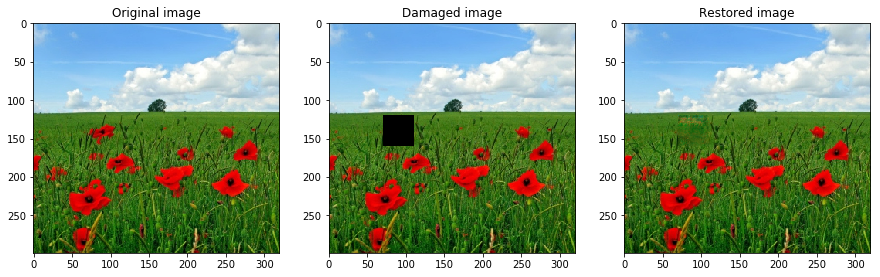

In [182]:

Inpainting ( "img4.jpg" , h=30 , stride=9 , alpha=1e-4 , i=140 , j=90 , height=40 )

In [226]:
def Inpainting (img_path , h , stride , i , j , height , alpha, max_iter = 60000, verbose=True):
    t_init = time.time()
    array_img =  read_im(img_path)
    print("image shape : " , array_img.shape )

  #rgb TO hsv
    imgNormalized_hsv = rgb_to_hsv(array_img)

    img_hole = del_patch(imgNormalized_hsv, i, j, height)
    img_hole_rgb = del_patch(array_img, i, j, height)
    
    b_pixels = get_boundary_pixels(img_hole)
    
    D = get_dictionary(img_hole, h, stride)
    print("dictionary shape : " , D.shape )
    
    model = linear_model.Lasso(alpha=alpha, max_iter=max_iter)
  # ALGORITHM 
    i  = 0

    while (len(b_pixels) > 0):
        gc.collect()
        
        centre_pixel, Y = naive_high_priority_pixel(img_hole, h, b_pixels)
        Y = Y.ravel()
        train_iter = []
        test_iter = []
        for k in range(len(Y)):
            if(Y[k]==-100):
                test_iter.append(k)
            else:
                train_iter.append(k)
        model.fit(D[train_iter], Y[train_iter])
        if ( verbose ) :
            print("iteration ",i," len b_pixel : ",len(b_pixels))
            print("selected pixel : ",centre_pixel)
            print("selected patch shape : ",Y.shape )
            print("number of none zero components: {0:.2f}  %".format(100*np.where ( model.coef_ != 0 )[0].shape[0]/D.shape[1]))
        Y_pred = model.predict(D[test_iter])
        Y[test_iter] = Y_pred
        fill_patch(img_hole, centre_pixel[0], centre_pixel[1], h, Y)
        b_pixels = get_boundary_pixels(img_hole)
        i += 1
        
    result_rgb = hsv_to_rgb(img_hole)

    print("elapsed time: {0:.2f} seconds".format(time.time() - t_init))
  # Plotting résults  
    show_imgs_results ( array_img , img_hole_rgb , result_rgb )
  

image shape :  (298, 302, 3)
iteration  0  len b_pixel :  239
selected pixel :  (84, 188)
selected patch shape :  (4800,)
number of none zero components: 4.41  %
iteration  1  len b_pixel :  238
selected pixel :  (104, 188)
selected patch shape :  (4800,)
number of none zero components: 4.59  %
iteration  2  len b_pixel :  238
selected pixel :  (84, 208)
selected patch shape :  (4800,)
number of none zero components: 3.97  %
iteration  3  len b_pixel :  237
selected pixel :  (104, 208)
selected patch shape :  (4800,)
number of none zero components: 5.82  %
iteration  4  len b_pixel :  238
selected pixel :  (84, 228)
selected patch shape :  (4800,)
number of none zero components: 5.47  %
iteration  5  len b_pixel :  237
selected pixel :  (84, 248)
selected patch shape :  (4800,)
number of none zero components: 5.38  %
iteration  6  len b_pixel :  218
selected pixel :  (84, 268)
selected patch shape :  (4800,)
number of none zero components: 4.41  %
iteration  7  len b_pixel :  198
selec

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23147845459011962, tolerance: 0.05896672728236781
  positive)


iteration  17  len b_pixel :  79
selected pixel :  (124, 268)
selected patch shape :  (4800,)
number of none zero components: 5.64  %


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06911651702540217, tolerance: 0.045686071251328
  positive)


iteration  18  len b_pixel :  59
selected pixel :  (153, 248)
selected patch shape :  (4800,)
number of none zero components: 6.00  %


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09469551260629094, tolerance: 0.064226323846936
  positive)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration  19  len b_pixel :  20
selected pixel :  (158, 268)
selected patch shape :  (4800,)
number of none zero components: 5.64  %
elapsed time: 567.91 seconds


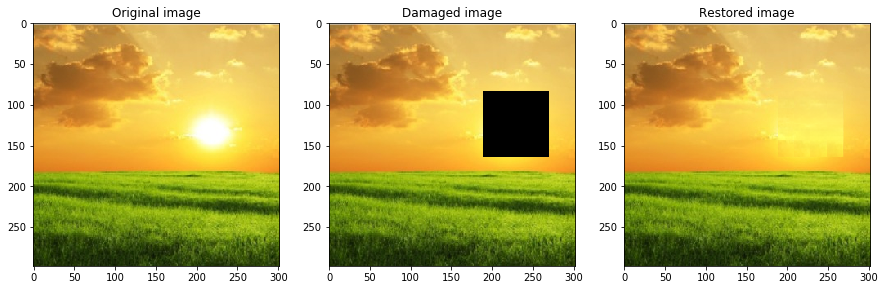

In [215]:
Inpainting ( "img5.jpg" , h=40 , stride=7 , alpha=1e-4 , i=124 , j=229 , height=81, max_iter = 7000, verbose = True)

image shape :  (299, 320, 3)
iteration  0  len b_pixel :  124
selected pixel :  (119, 69)
selected patch shape :  (2700,)
number of none zero components: 34.13  %
iteration  1  len b_pixel :  123
selected pixel :  (119, 84)
selected patch shape :  (2700,)
number of none zero components: 35.21  %
iteration  2  len b_pixel :  123
selected pixel :  (119, 100)
selected patch shape :  (2700,)
number of none zero components: 37.69  %
iteration  3  len b_pixel :  94
selected pixel :  (134, 69)
selected patch shape :  (2700,)
number of none zero components: 24.51  %
iteration  4  len b_pixel :  93
selected pixel :  (150, 69)
selected patch shape :  (2700,)
number of none zero components: 29.59  %
iteration  5  len b_pixel :  79
selected pixel :  (134, 84)
selected patch shape :  (2700,)
number of none zero components: 25.38  %
iteration  6  len b_pixel :  78
selected pixel :  (134, 104)
selected patch shape :  (2700,)
number of none zero components: 31.53  %
iteration  7  len b_pixel :  49
sel

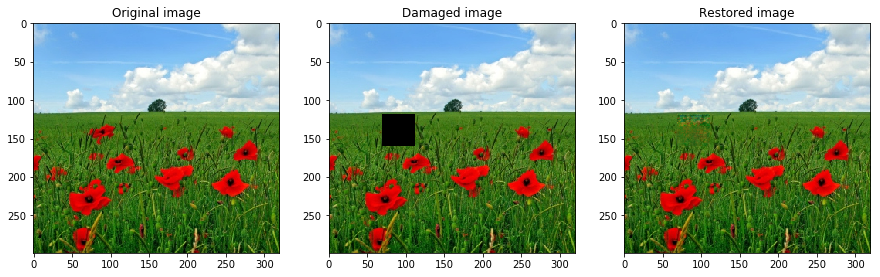

In [216]:
Inpainting ( "img4.jpg" , h=30 , stride=9 , alpha=1e-4 , i=140 , j=90 , height=42)

image shape :  (360, 626, 3)
dictionary shape :  (2352, 3728)
iteration  0  len b_pixel :  334
selected pixel :  (94, 407)
selected patch shape :  (2352,)
number of none zero components: 2.20  %
iteration  1  len b_pixel :  333
selected pixel :  (94, 421)
selected patch shape :  (2352,)
number of none zero components: 2.25  %
iteration  2  len b_pixel :  333
selected pixel :  (94, 435)
selected patch shape :  (2352,)
number of none zero components: 2.47  %
iteration  3  len b_pixel :  333
selected pixel :  (94, 449)
selected patch shape :  (2352,)
number of none zero components: 2.52  %
iteration  4  len b_pixel :  333
selected pixel :  (94, 463)
selected patch shape :  (2352,)
number of none zero components: 2.36  %
iteration  5  len b_pixel :  333
selected pixel :  (94, 477)
selected patch shape :  (2352,)
number of none zero components: 1.64  %
iteration  6  len b_pixel :  333
selected pixel :  (94, 491)
selected patch shape :  (2352,)
number of none zero components: 1.23  %
iterati

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027803206231492794, tolerance: 0.014079309999222816
  positive)


iteration  25  len b_pixel :  276
selected pixel :  (201, 407)
selected patch shape :  (2352,)
number of none zero components: 7.24  %
iteration  26  len b_pixel :  263
selected pixel :  (136, 421)
selected patch shape :  (2352,)
number of none zero components: 1.50  %
iteration  27  len b_pixel :  262
selected pixel :  (150, 421)
selected patch shape :  (2352,)
number of none zero components: 1.64  %
iteration  28  len b_pixel :  262
selected pixel :  (136, 435)
selected patch shape :  (2352,)
number of none zero components: 1.18  %
iteration  29  len b_pixel :  261
selected pixel :  (136, 449)
selected patch shape :  (2352,)
number of none zero components: 1.07  %
iteration  30  len b_pixel :  261
selected pixel :  (150, 435)
selected patch shape :  (2352,)
number of none zero components: 1.56  %
iteration  31  len b_pixel :  261
selected pixel :  (136, 463)
selected patch shape :  (2352,)
number of none zero components: 1.39  %
iteration  32  len b_pixel :  262
selected pixel :  (16

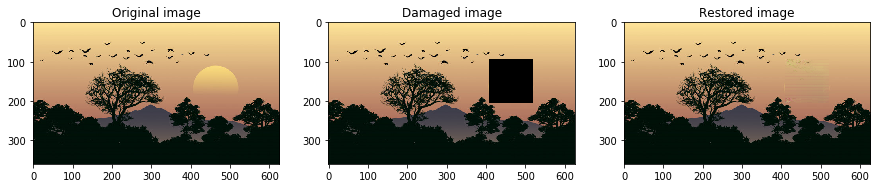

In [243]:
Inpainting( "img6.jpg" , h=28 , stride=7 , alpha=6e-4 , i=150 , j=463 , height=112 , max_iter = 5000)

image shape :  (299, 320, 3)
dictionary shape :  (972, 1063)
iteration  0  len b_pixel :  71
selected pixel :  (98, 149)
selected patch shape :  (972,)
number of none zero components: 4.14  %
iteration  1  len b_pixel :  70
selected pixel :  (98, 158)
selected patch shape :  (972,)
number of none zero components: 4.42  %
iteration  2  len b_pixel :  70
selected pixel :  (98, 168)
selected patch shape :  (972,)
number of none zero components: 4.52  %
iteration  3  len b_pixel :  53
selected pixel :  (107, 149)
selected patch shape :  (972,)
number of none zero components: 4.23  %
iteration  4  len b_pixel :  52
selected pixel :  (116, 149)
selected patch shape :  (972,)
number of none zero components: 2.54  %
iteration  5  len b_pixel :  44
selected pixel :  (107, 158)
selected patch shape :  (972,)
number of none zero components: 4.23  %
iteration  6  len b_pixel :  43
selected pixel :  (119, 158)
selected patch shape :  (972,)
number of none zero components: 5.36  %
iteration  7  len 

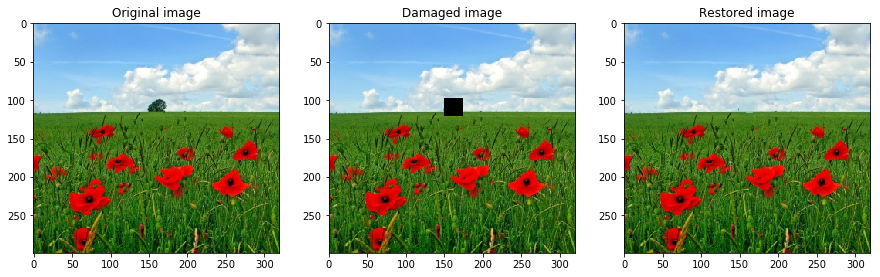

In [248]:
Inpainting( "img4.jpg" , h=18 , stride=9 , alpha=7e-4 , i=110 , j=162 , height=25 , max_iter = 40000)

image shape :  (225, 225, 3)
dictionary shape :  (300, 11135)
iteration  0  len b_pixel :  107
selected pixel :  (165, 26)
selected patch shape :  (300,)
number of none zero components: 0.80  %
iteration  1  len b_pixel :  106
selected pixel :  (165, 31)
selected patch shape :  (300,)
number of none zero components: 0.76  %
iteration  2  len b_pixel :  106
selected pixel :  (165, 36)
selected patch shape :  (300,)
number of none zero components: 0.92  %
iteration  3  len b_pixel :  106
selected pixel :  (170, 26)
selected patch shape :  (300,)
number of none zero components: 0.69  %
iteration  4  len b_pixel :  105
selected pixel :  (175, 26)
selected patch shape :  (300,)
number of none zero components: 0.96  %
iteration  5  len b_pixel :  105
selected pixel :  (180, 26)
selected patch shape :  (300,)
number of none zero components: 1.01  %
iteration  6  len b_pixel :  105
selected pixel :  (185, 26)
selected patch shape :  (300,)
number of none zero components: 0.85  %
iteration  7  

iteration  62  len b_pixel :  12
selected pixel :  (195, 62)
selected patch shape :  (300,)
number of none zero components: 1.10  %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration  63  len b_pixel :  2
selected pixel :  (200, 62)
selected patch shape :  (300,)
number of none zero components: 1.05  %
elapsed time: 482.35 seconds


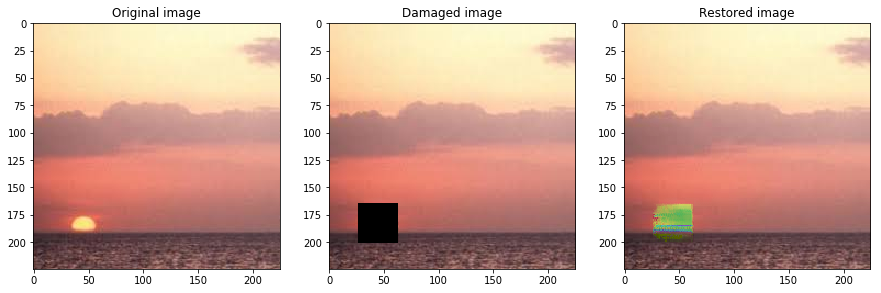

In [262]:
Inpainting( "img2.jpg" , h=10 , stride=2 , alpha=1e-4 , i=183 , j=45 , height=37 , max_iter = 10000)